In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
import simfin as sf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 2 s (started: 2022-10-10 14:17:28 +08:00)


In [2]:
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

time: 0 ns (started: 2022-10-10 14:17:30 +08:00)


# Preparation of data for backtesting

- X loads all the fundamental ratios, without any labels on the stock performance.
- y loads all the annual performance of the stocks, corresponding to X index
- y_withdata loads the data of each stock on reporting date and the data one year later.

In [3]:
# Read in stock price fundamental ratios
X = pickle.load(open('./data/fundamentals3.pkl', 'rb'))

# Read in annual performance
y = pickle.load(open('./data/performance3.pkl', 'rb'))
y = y['Returns']

# Read in annual performance
y_withdata = pickle.load(open('./data/performance2.pkl', 'rb'))

time: 31 ms (started: 2022-10-10 14:17:30 +08:00)


In [4]:
X.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422


time: 15 ms (started: 2022-10-10 14:17:31 +08:00)


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38307 entries, 0 to 38306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EV_EBIT        38307 non-null  float64
 1   OI_NWCFA       38307 non-null  float64
 2   PE             38307 non-null  float64
 3   PB             38307 non-null  float64
 4   PS             38307 non-null  float64
 5   OI_IntExp      38307 non-null  float64
 6   WorkingCap     38307 non-null  float64
 7   ROE            38307 non-null  float64
 8   ROCE           38307 non-null  float64
 9   DE             38307 non-null  float64
 10  DebtRatio      38307 non-null  float64
 11  CashRatio      38307 non-null  float64
 12  AssetTurnover  38307 non-null  float64
 13  GPM            38307 non-null  float64
 14  WC_TA          38307 non-null  float64
 15  RE_TA          38307 non-null  float64
 16  EBIT_TA        38307 non-null  float64
 17  Equity_Liab    38307 non-null  float64
dtypes: flo

In [6]:
y.head()

0    0.563351
1    0.535595
2    0.198018
3    0.076426
4   -0.050044
Name: Returns, dtype: object

time: 0 ns (started: 2022-10-10 14:17:31 +08:00)


In [7]:
y.isnull().sum()

8657

time: 0 ns (started: 2022-10-10 14:17:31 +08:00)


In [8]:
y_withdata.head()

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
0,A,2016-10-31,43.33,1556762.0,2017-10-31,67.74,1609938.0
1,A,2017-01-31,48.04,2552612.0,2018-01-31,73.77,1949108.0
2,A,2017-04-30,55.50,1897018.0,2018-04-30,66.49,2277705.0
3,A,2017-07-31,60.32,1038744.0,2018-07-31,64.93,2539265.0
4,A,2017-10-31,67.74,1609938.0,2018-10-31,64.35,3820987.0


time: 0 ns (started: 2022-10-10 14:17:31 +08:00)


In [9]:
# X and Y (splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", 
                    index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", 
                   index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", 
                    index_col=0)['Returns']
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", 
                   index_col=0)['Returns']

time: 125 ms (started: 2022-10-10 14:17:31 +08:00)


In [82]:
y_withdata_test = pd.DataFrame()
y_withdata_test = y_withdata.loc[y_test.index, :]

time: 0 ns (started: 2022-10-10 15:23:27 +08:00)


In [11]:
rf = pickle.load(open('rf_regressor.p', 'rb'))

time: 16 ms (started: 2022-10-10 14:17:31 +08:00)


In [12]:
# fit and predict using Random Forest
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

time: 17.3 s (started: 2022-10-10 14:17:31 +08:00)


In [13]:
mse_train = mean_squared_error(y_train, rf.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 0.6734017695836776
Test MSE: 1.017684904552254
Generalisation: -51.126%
time: 141 ms (started: 2022-10-10 14:17:48 +08:00)


## Download the daily price data

In [14]:
# Set your SimFin+ API-key for downloading data.
sf.set_api_key('nYdjeL237mt7QaQ4OZTaPa4Xn3YECrTH')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

time: 0 ns (started: 2022-10-10 14:17:48 +08:00)


In [15]:
# Download the data from the SimFin server and load into a Pandas DataFrame.
df_prices = sf.load_shareprices(variant='daily', market='us')
df_prices.reset_index(inplace=True)

Dataset "us-shareprices-daily" on disk (2 days old).
- Loading from disk ... Done!
time: 10.3 s (started: 2022-10-10 14:17:48 +08:00)


In [16]:
# Print the first rows of the data.
df_prices.head()

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,A,2016-10-06,45846,47.01,46.88,47.43,47.30,45.09,NaN,1772801,324384755.0
1,A,2016-10-07,45846,47.33,46.99,47.49,47.38,45.16,NaN,1663127,324384755.0
2,A,2016-10-10,45846,47.58,47.55,48.15,47.69,45.46,NaN,1544958,324384755.0
3,A,2016-10-11,45846,47.19,45.42,47.19,45.69,43.55,NaN,2912537,324384755.0
4,A,2016-10-12,45846,45.78,45.42,45.81,45.47,43.34,NaN,1736076,324384755.0


time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


In [17]:
df_prices.shape

(3172869, 11)

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


# Define Functions here

### Function 0: Get the y performance from a dataframe

In [18]:
# We pass a dataframe, we want the function to calculate the % returns between two dates.

def getYPerf(y1):
    y2=pd.DataFrame()
    y2["Ticker"] = y1["Ticker"]
    y2["Perf"]=(y1["Open2"]-y1["Open1"])/y1["Open1"]
    
    # Any row that performance cannot be calculated to be filled with zeros
    y2[y2["Perf"].isnull()]=0
    return y2

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 1: Get stock price between dates

In [19]:
# To get the stock price between 2 dates for a particular ticker

def getStockPriceBetweenDates(date1, date2, ticker, df_prices):
    rows = df_prices.loc[(df_prices["Date"]>date1) & 
                         (df_prices["Date"]<date2) & 
                         (df_prices["Ticker"]==ticker)]
    return rows

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


In [20]:
# Testing above function
getStockPriceBetweenDates('2016-10-09', '2016-10-15', 'AAPL', df_prices)

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
10283,AAPL,2016-10-10,111052,28.75,28.68,29.19,29.01,27.05,NaN,144943824,2.134466e+10
10284,AAPL,2016-10-11,111052,29.43,29.05,29.67,29.07,27.11,NaN,256164172,2.134466e+10
10285,AAPL,2016-10-12,111052,29.34,29.19,29.50,29.34,27.35,NaN,150347148,2.134466e+10
10286,AAPL,2016-10-13,111052,29.20,28.93,29.36,29.25,27.27,NaN,140769624,2.134466e+10
10287,AAPL,2016-10-14,111052,29.47,29.28,29.54,29.41,27.42,NaN,142608764,2.132925e+10


time: 266 ms (started: 2022-10-10 14:17:59 +08:00)


### Function 2: Get stock price data

In [21]:
# Expansion of the above
# Will do a filter on all the prices to get stock price we want on the days we want

def getStockPriceData(ticker, y, mask, dailystock_prices):
    date1 = y[mask][y[mask]["Ticker"] == ticker]["Date1"].values[0]
    date2 = y[mask][y[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2, ticker, dailystock_prices)
    return rows

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 3: Get data for date range (get the price data every week) 

In [22]:
# Weekly date index is the weekly dates and rows are the stock price data

def getDataForDateRange(weekly_date_index, rows):
   
    # Create an empty dataframe to store the weekly stock data later
    WeeklyStockDataRows = pd.DataFrame()

    for i in weekly_date_index:
        WeeklyStockDataRows = WeeklyStockDataRows.append\
        (rows.iloc[rows.index.get_loc(i, method="nearest")])
    
    return WeeklyStockDataRows

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 4: Get Stock Time Series

In [23]:
# Returns the rows from df_prices of the stocks and years that we want
# Get stock price a time series Dataframe for list of tickers
# Index is usually weekly, so we know what price info to extract

def getStockTimeSeries(dateTimeIndex, y_withData, tickers_list, mask, df_prices):

    # Empty dateframe to record weekly stock returns
    stockReturns = pd.DataFrame(index=dateTimeIndex)
    
    # Change Date Format of weekly date time index
    weekly_dti = dateTimeIndex.strftime('%Y-%m-%d')
    rows = pd.DataFrame()
    
    for tick in tickers_list:
        # Rows is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_withData, mask, df_prices)
        
        # Change the index of the time series data to be the "Date"
        rows.index = pd.DatetimeIndex(rows["Date"])

        # Gets our stock price data to be in a weekly format, using the closest day if the data for a day we want is missing.
        WeeklyStockDataRows = getDataForDateRange(weekly_dti, rows)

        # We can choose to use Open, Close, or Adj Close
        stockReturns[tick] = WeeklyStockDataRows["Close"].values
        
    return stockReturns

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 5: Get portfolio relative time series (Start from base level of 100)

In [24]:
# Takes the dataframe of stock returns (from previous function), one column per stock
# Price at the start is 1, all other values after is the relative performance
# Adds a column "PortValue" to record the portfolio value

def getPortfolioRelativeTimeSeries(stockReturns):
    
    for tick in stockReturns.columns:
        stockReturns[tick] = stockReturns[tick]/stockReturns[tick][0]
            
    # Because it is equally weighted, we take the sum of the returns divide by number of tickers
    stockReturns["PortValue"] = stockReturns.sum(axis=1)/(stockReturns.columns.shape[0])
    return stockReturns

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 6: Get Portfolio Time Series for the year

In [25]:
# This function runs a backtest and returns the selected stocks performance for 1 year (from start of year)
# df_prices is daily(mostly) stock price time series for all stocks

def getPortTimeSeriesForYear(datestart, y_withData, X, df_prices, model):

    # Get y dataframe with ticker and ticker performance only
    # Those with null values, will just fill up with zeros for tickers and returns
    y = getYPerf(y_withData)
    
    # For this year, we want to predict on stocks which reported 2 months before start of year up to Oct.
    # Time period Oct to Oct
    thisYearMask = y_withData["Date1"].between(pd.to_datetime(datestart) - pd.Timedelta(days=60),\
                                               pd.to_datetime(datestart) + pd.Timedelta(days=300))
    
    # Get return prediction from model
    y_pred = model.predict(X[thisYearMask])
    
    # Make it a DataFrame so we can select the top predictions
    y_pred = pd.DataFrame(y_pred)

    # Create a mask to find the list of top 10 stocks with highest predicted performance
    # Essentially, which are the returns that are higher than the 11th largest value.
    top10mask = (y_pred[0]> y_pred.nlargest(11,0).tail(1)[0].values[0]) 
    
    # Weekly Date Index
    weeklyDateIndex = pd.date_range(start=datestart, periods=52, freq='W')
    
    # 10 best performing stocks of the predictions 
    ticker_list = y[thisYearMask].reset_index(drop=True)[top10mask]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    ticker_list = list(filter(lambda weeklyDateIndex: weeklyDateIndex != 0, ticker_list))

    # After we have our 10 stock picks, we want to find the stock prices and performances
    # Returns dataFrame of the time, tickers as the column keys and stocks prices
    stockReturns = getStockTimeSeries(weeklyDateIndex, y_withData, ticker_list, thisYearMask, df_prices)
    
    # Transform the stock prices above into relative returns
    stockReturnsRel = getPortfolioRelativeTimeSeries(stockReturns)
    
    # Returns the relative performance dataframe, the cumulative portfolio perf, and the ticker list of top 10 stocks
    return [stockReturnsRel, stockReturnsRel["PortValue"], ticker_list]

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


### Function 7: Get portfolio time series

In [26]:
def getPortTimeSeries(y_withData, X, df_prices, model, verbose=True):

    # Set date range to make stock picks over (2016 to 2020)
    date_range = pd.date_range(start='2017-01-01', periods=4, freq='AS')
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    
    perfRef=1 # Performance starts at 1.
    
    for curr_date in date_range:
        
        # Refer to function 6
        # Will give us a relative performance dataframe, cumulative portfolio perf, and top10 ticker list
        [comp, this_year_perf, ticker_list] = getPortTimeSeriesForYear(curr_date, y_withData, X, df_prices, model)
        
        # For we want text output, set verbose=True
        if verbose: 
            # Returns the last date performance of that particular year
            print("Backtest performance for year starting ", curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100, 2), "%")
            print("With these top 10 stocks:", ticker_list, '\n')
        
            for tick in ticker_list:
                print(tick, "Performance was:", round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Append performance for every year together
        this_year_perf = this_year_perf * perfRef
        port_perf_all_years = pd.concat([port_perf_all_years, this_year_perf])
        
        # Update perfRef to be the last value of this year's relative performance
        perfRef = this_year_perf.iloc[-1]

    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
        
    return port_perf_all_years

time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


# Test run the main function!

In [27]:
y_withdata_test.head()

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
26780,PK,2016-12-31,30.21,33221775.0,2017-12-31,28.87,1294841.0
16361,HTGM,2021-06-30,5.99,27359.0,2022-06-30,NaN,NaN
27115,PNW,2020-12-31,79.05,539364.0,2021-12-31,NaN,NaN
18629,KE,2018-06-30,18.25,53290.0,2019-06-30,16.25,67064.0
258,ABIO,2021-06-30,3.52,92318.0,2022-06-30,NaN,NaN


time: 16 ms (started: 2022-10-10 14:17:59 +08:00)


In [28]:
X_test.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
26780,60.848124,0.046325,82.567425,2.223304,3.505221,6.302326,1.794257,0.026927,0.021920,1.776311,1.562964,0.234207,1.350318,0.168701,0.201648,0.366973,0.016355,0.562964
16361,32.637788,-0.213905,45.001480,5.013262,7.888369,-600.000000,0.392781,0.111402,0.149403,1.211413,1.825482,0.110870,16.223218,0.388446,-0.332475,-0.392096,0.067599,0.825482
27115,61.658163,-0.559638,82.337440,4.572042,4.289662,12.220930,0.751531,0.055528,0.044469,1.938144,1.515958,0.352285,7.094106,0.235139,-0.099721,0.338676,0.026622,0.515958
18629,-19.912200,-0.369821,-16.558448,-9.210577,5.585790,-20.246377,1.763218,0.556246,-0.485598,0.000000,0.708518,0.490134,20.584838,0.056471,0.416454,-9.030694,-0.220629,-0.291482
258,206.196985,0.060173,257.078841,4.765257,18.766822,6.264463,1.433938,0.018536,0.013829,1.194663,1.837056,0.339378,0.977109,0.575330,0.070234,0.386151,0.011591,0.837056


time: 0 ns (started: 2022-10-10 14:17:59 +08:00)


# Do a backtest with the RandomForestRegressor

In [29]:
backTest = getPortTimeSeries(y_withdata_test, X_test, df_prices, rf)

# Final print to find the cumulative performance
print('Cumulative Performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2017-01-01 00:00:00  is: 10.95 %
With these top 10 stocks: ['J', 'RAIL', 'CSOD', 'POOL', 'O', 'AOSL', 'APTI', 'ARMK', 'MNRO', 'MODN'] 

J Performance was: 13.59 %
RAIL Performance was: -15.34 %
CSOD Performance was: -15.83 %
POOL Performance was: 23.96 %
O Performance was: 0.33 %
AOSL Performance was: -0.7 %
APTI Performance was: 33.43 %
ARMK Performance was: 16.17 %
MNRO Performance was: 1.75 %
MODN Performance was: 52.17 %
---------------------------------------------
Backtest performance for year starting  2018-01-01 00:00:00  is: -21.47 %
With these top 10 stocks: ['MIDD', 'CME', 'ABC', 'CSGS', 'JAGX', 'ICHR', 'PII', 'ALE', 'NVEC', 'NUE'] 

MIDD Performance was: -18.2 %
CME Performance was: 19.29 %
ABC Performance was: -13.21 %
CSGS Performance was: -19.47 %
JAGX Performance was: -72.76 %
ICHR Performance was: -29.53 %
PII Performance was: -41.16 %
ALE Performance was: 2.27 %
NVEC Performance was: -28.49 %
NUE Performance was: -13.43 %
------

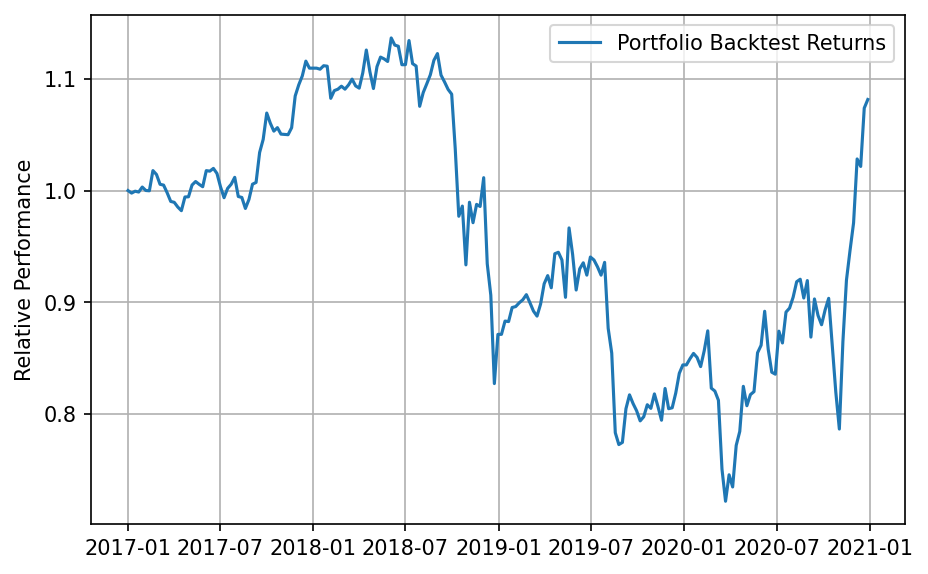

time: 187 ms (started: 2022-10-10 14:18:12 +08:00)


In [30]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

## Small test

In [38]:
y_small = getYPerf(y_withdata_test)
# y_small is cut down version of y with stock returns only (actual returns)

# Create a boolean mask for the backtest year we are interested in
myDate = pd.to_datetime('2017-12-31')
mask2018 = y_withdata_test["Date1"].between(pd.to_datetime(myDate)-pd.Timedelta(days=60),
                                           pd.to_datetime(myDate)+pd.Timedelta(days=60))

time: 0 ns (started: 2022-10-10 14:32:22 +08:00)


In [39]:
# Checking the mask works
y_withdata_test[mask2018]

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
3142,ASPN,2017-12-31,4.93,18493.0,2018-12-31,2.05,156082.0
12926,FEIM,2018-01-31,9.39,1920.0,2019-01-31,12.64,10812.0
19106,KRA,2017-12-31,48.38,740298.0,2018-12-31,22.33,231927.0
21555,META,2017-12-31,177.68,17694891.0,2018-12-31,134.45,24625308.0
16247,HSKA,2017-12-31,80.21,41660.0,2018-12-31,90.29,53384.0
...,...,...,...,...,...,...,...
15442,HDP,2017-12-31,20.21,621434.0,2018-12-31,14.30,528682.0
18203,JHG,2017-12-31,38.31,680501.0,2018-12-31,20.54,1337331.0
6147,CBI,2017-12-31,16.25,3059116.0,2018-12-31,NaN,NaN
13151,FIVE,2018-01-31,66.84,1017743.0,2019-01-31,121.59,645062.0


time: 16 ms (started: 2022-10-10 14:32:23 +08:00)


In [43]:
X_test[mask2018]

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
3142,105.053812,0.055192,134.125749,5.881318,15.713083,38.230769,2.761394,0.043849,0.030365,1.271104,1.786718,1.152432,0.647072,0.429323,0.265854,0.916180,0.025782,0.786718
12926,-26.577028,-0.118934,-25.086523,16.278464,34.352946,-6.403815,5.494478,-0.648893,-0.110309,5.135266,1.194732,5.089309,10.371673,0.992139,0.784335,-2.525026,-0.091059,0.194732
19106,117.765896,0.072211,132.397475,10.946758,34.654373,-600.000000,8.256358,0.082681,0.063605,0.534573,2.870653,6.313327,3.593692,0.593702,0.758023,0.691392,0.056961,1.870653
21555,62.981724,0.108775,70.148974,2.260959,5.437106,8.380282,1.761102,0.032231,0.024511,1.104633,1.905278,0.251578,2.649800,0.557764,0.112210,0.323425,0.020897,0.905278
16247,91.315951,0.106487,100.631698,8.180173,26.371919,-600.000000,2.744522,0.081288,0.078558,0.384432,3.601242,1.696368,1.444258,0.673373,0.402870,0.723007,0.060416,2.601242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15442,-72.617109,-0.018451,-59.339805,2.038776,1.097548,600.000000,1.353523,-0.034358,-0.015085,3.021924,1.330915,0.064711,2.892155,0.351630,0.161978,0.124758,-0.008173,0.330915
18203,70.201604,0.156649,84.836608,5.679075,13.978660,10.640326,1.840458,0.066941,0.043277,1.596808,1.626249,0.291673,1.540259,0.554135,0.126966,0.657120,0.036739,0.626249
6147,29.717089,0.252076,25.888491,7.716865,18.665852,-401.380435,27.023242,0.298081,0.242008,0.035517,29.155439,15.035034,40.534282,0.733198,0.863998,0.086066,0.233973,20.000000
13151,-74.783454,-0.046312,-71.276813,-3.648416,16.197117,-4.564444,2.396555,0.051187,-0.067896,0.000000,0.511489,2.232175,2.319719,0.000000,0.518577,-5.286128,-0.042685,-0.488511


time: 16 ms (started: 2022-10-10 14:34:50 +08:00)


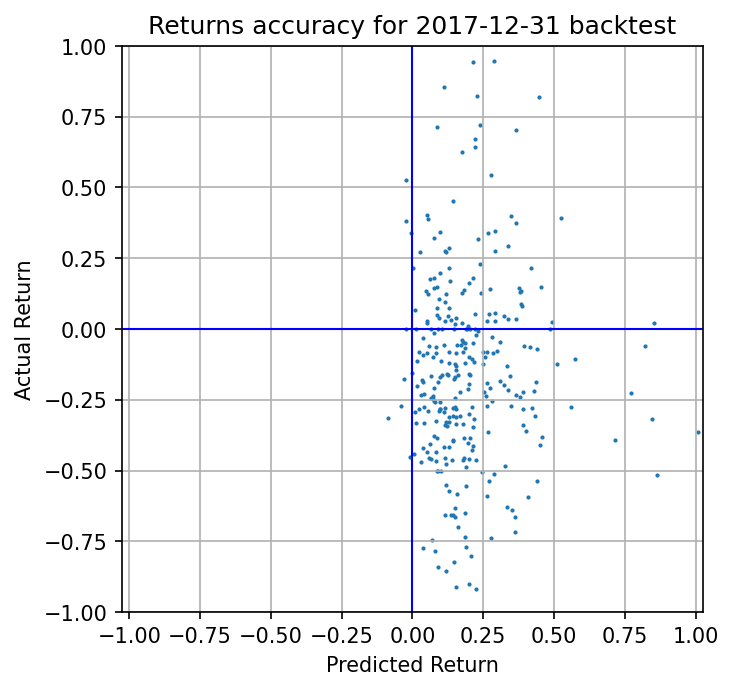

time: 203 ms (started: 2022-10-10 14:18:12 +08:00)


In [34]:
# Load the model pipeline
ml_model_pipeline = pickle.load(open("rf_regressor.p", "rb" ))

# Get stock performance predictions
y_pred = ml_model_pipeline.predict(X_test[mask2018])
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

# Now output scatter graph to see prediction/actual
# for that year only.
plt.figure(figsize=(5,5))
plt.scatter(y_pred[0], y_small[mask2018]["Perf"], s=1)

# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {}-{}-{} backtest'.format(myDate.year, myDate.month, myDate.day))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [35]:
# Top stocks picked, and predicted performance.
bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked and predicted performance is:")
print(y_small[mask2018].reset_index(drop=True)[bl_bestStocks]["Ticker"])
print(y_pred[bl_bestStocks])

print("\nActual performance was: ")
print(y_small[mask2018].reset_index(drop=True)[bl_bestStocks])

'''# Calc Altman Z score.
# To check if these companies were going to go bankrupt
Z = 3.25 \
+ 6.51 * X_test[mask2018].reset_index(drop=True)[bl_bestStocks]['(CA-CL)/TA']\
+ 3.26 * X_test[mask2018].reset_index(drop=True)[bl_bestStocks]['RE/TA']\
+ 6.72 * X_test[mask2018].reset_index(drop=True)[bl_bestStocks]['EBIT/TA']\
+ 1.05 * X_test[mask2018].reset_index(drop=True)[bl_bestStocks]['Book Equity/TL']
print('\nZ scores:\n',Z)''';


Top predicted perf. stocks picked and predicted performance is:
42      MSA
68     CLDR
70      FTI
81     BURL
149     PXD
237       J
303    ALPN
Name: Ticker, dtype: object
            0
42   2.373454
68   2.258538
70   1.010346
81   1.540793
149  1.153743
237  1.285987
303  1.116924

Actual performance was: 
    Ticker      Perf
42     MSA  0.195510
68    CLDR -0.289488
70     FTI -0.364028
81    BURL  0.352467
149    PXD -0.248594
237      J -0.132632
303   ALPN -0.651515
time: 0 ns (started: 2022-10-10 14:18:12 +08:00)


In [44]:
# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask2018]["Perf"].reset_index(drop=True)[bl_bestStocks].values.mean())

Backtest return is:
-0.1626113865907846
time: 0 ns (started: 2022-10-10 14:37:23 +08:00)


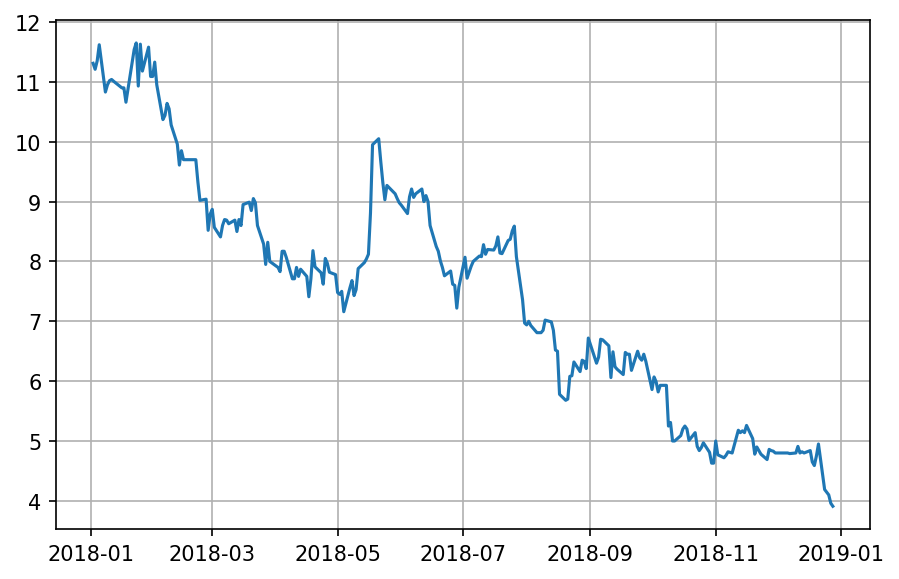

time: 281 ms (started: 2022-10-10 14:41:14 +08:00)


In [45]:
# Look at stock price of one of the companies
rows = getStockPriceData("ALPN", 
                         y_withdata_test, 
                         mask2018, 
                         df_prices, 
                         )

plt.plot(rows["Date"], rows["Close"]) # Adj. Close
plt.grid(True)

['MSA' 'CLDR' 'FTI' 'BURL' 'PXD' 'J' 'ALPN']


No handles with labels found to put in legend.


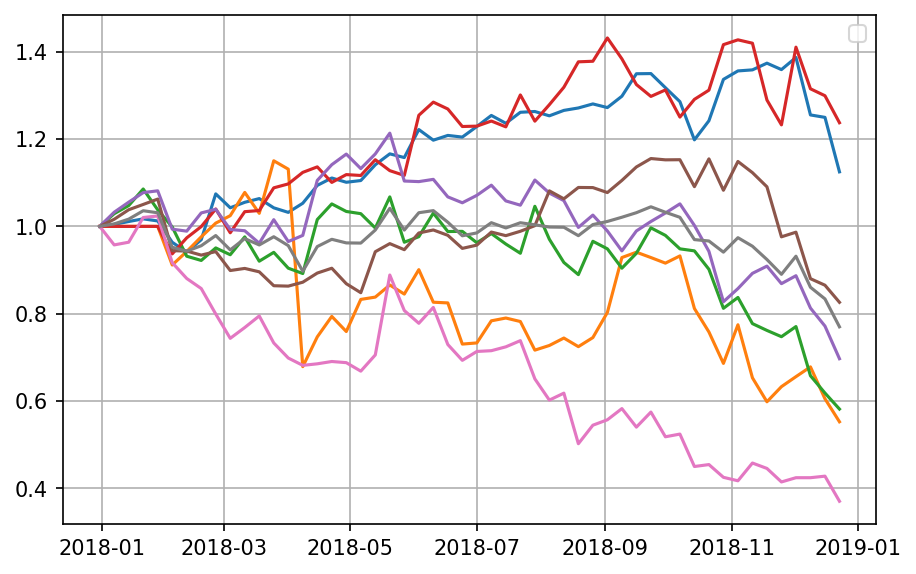

time: 2.38 s (started: 2022-10-10 14:41:50 +08:00)


In [49]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W')

# 7 greatest performance stocks of y_pred 
ticker_list = y_withdata_test[mask2018].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
ticker_list = y_small[mask2018].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
print(ticker_list)

stockRet = getStockTimeSeries(date_range, y_withdata_test, 
                              ticker_list, 
                              mask2018, 
                              df_prices)

stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

stockRetRel.head()

plt.plot(stockRetRel)
plt.legend()
plt.grid();

# S&P 500 historical data

In [66]:
spy = pd.read_csv("S&P500.csv", index_col='Date', parse_dates=True).sort_index()

time: 31 ms (started: 2022-10-10 14:48:17 +08:00)


In [67]:
spy = spy.apply(lambda x: x.str.replace(',', ''))
spy = spy.astype(float)

time: 0 ns (started: 2022-10-10 14:48:19 +08:00)


In [68]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 320 entries, 2016-08-29 to 2022-10-07
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         320 non-null    float64
 1   High         320 non-null    float64
 2   Low          320 non-null    float64
 3   Close*       320 non-null    float64
 4   Adj Close**  320 non-null    float64
 5   Volume       320 non-null    float64
dtypes: float64(6)
memory usage: 17.5 KB
time: 0 ns (started: 2022-10-10 14:48:20 +08:00)


In [69]:
spy = spy.loc[(spy.index>='2017-01-01') & 
                         (spy.index<'2020-12-31')]

time: 0 ns (started: 2022-10-10 14:48:23 +08:00)


In [70]:
spy

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2017-01-02,2251.57,2282.10,2245.13,2276.98,2276.98,1.463713e+10
2017-01-09,2273.59,2279.27,2254.25,2274.64,2274.64,1.702021e+10
2017-01-16,2269.14,2276.96,2258.41,2271.31,2271.31,1.359118e+10
2017-01-23,2267.78,2300.99,2257.02,2294.69,2294.69,1.755594e+10
2017-01-30,2286.01,2298.31,2267.21,2297.42,2297.42,1.900101e+10
...,...,...,...,...,...,...
2020-11-30,3634.18,3699.20,3594.39,3699.12,3699.12,2.690281e+10
2020-12-07,3694.73,3712.39,3633.40,3663.46,3663.46,2.353356e+10
2020-12-14,3675.27,3726.70,3645.84,3709.41,3709.41,2.426542e+10


time: 15 ms (started: 2022-10-10 14:48:26 +08:00)


volatility of AI investor was:  0.16406108225726118
volatility of S&P 500 was:  0.23172422345963195


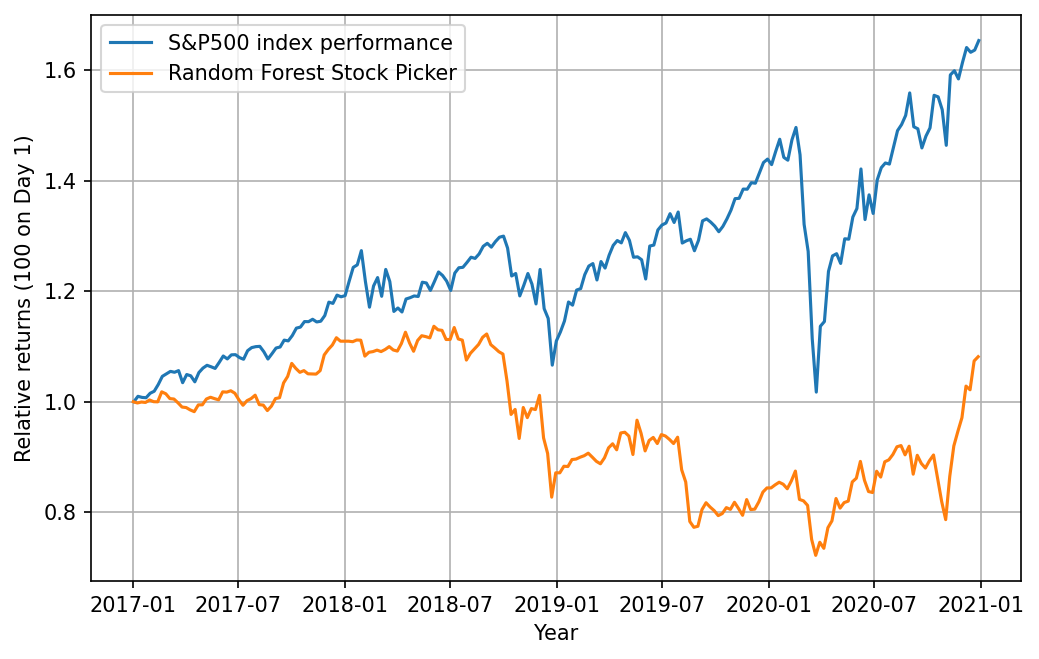

time: 171 ms (started: 2022-10-10 14:48:33 +08:00)


In [71]:
spy['Relative'] = spy["Open"]/spy["Open"][0]

plt.figure(figsize=(8,5))

# Plot the S&P relative performance from Day 1
plt.plot(spy['Relative'])

# Plot the portfolio backtest performance
plt.plot(backTest)

plt.grid()
plt.xlabel('Year')
plt.ylabel('Relative returns (100 on Day 1)')
plt.legend(['S&P500 index performance', 'Random Forest Stock Picker'])

print('volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

# Account for chance of default using Altman Z-score

Z = 3.25 + 6.51 X1 + 3.26 X2 + 6.72 X3 + 1.05 X4

The lower the Z score, the higher the risk of default. A Z score of 4 is roughly equivalent to B credit rating (about 5% risk of default). We use the following guidelines to determine which companies to choose:
- Z > 2.99: Non-bankrupt zone
- 1.81 < Z < 2.99: Grey zone
- Z < 1.81: Distress zone

In [78]:
# Top 10 stocks picked, and predicted performance.
mask_top10stocks = (y_pred[0] > y_pred.nlargest(11,0).tail(1)[0].values[0])

print("Top predicted perf. stocks picked and predicted performance is:")
print(y_small[mask2018].reset_index(drop=True)[mask_top10stocks]["Ticker"])
print(y_pred[mask_top10stocks])

print("\nActual performance was: ")
print(y_small[mask2018].reset_index(drop=True)[mask_top10stocks])

# Calculate Altman Z score.
# To give a sense of the risk of default
Z = 3.25 \
+ 6.51 * X_test[mask2018].reset_index(drop=True)[mask_top10stocks]['WC_TA']\
+ 3.26 * X_test[mask2018].reset_index(drop=True)[mask_top10stocks]['RE_TA']\
+ 6.72 * X_test[mask2018].reset_index(drop=True)[mask_top10stocks]['EBIT_TA']\
+ 1.05 * X_test[mask2018].reset_index(drop=True)[mask_top10stocks]['Equity_Liab']
print('\nZ scores:\n')
print(Z)

Top predicted perf. stocks picked and predicted performance is:
42      MSA
68     CLDR
70      FTI
81     BURL
140      IP
149     PXD
152    ARCW
219     ALE
237       J
303    ALPN
Name: Ticker, dtype: object
            0
42   2.373454
68   2.258538
70   1.010346
81   1.540793
140  0.845432
149  1.153743
152  0.864486
219  0.854523
237  1.285987
303  1.116924

Actual performance was: 
    Ticker      Perf
42     MSA  0.195510
68    CLDR -0.289488
70     FTI -0.364028
81    BURL  0.352467
140     IP -0.318403
149    PXD -0.248594
152   ARCW -0.516279
219    ALE  0.019938
237      J -0.132632
303   ALPN -0.651515

Z scores:

42    -40.797784
68      4.612640
70      5.692755
81    -13.390203
140     7.387082
149    10.012220
152     0.456816
219     0.657203
237   -69.731738
303   -40.105146
dtype: float64
time: 16 ms (started: 2022-10-10 15:08:06 +08:00)
